In [20]:
# Import des librairies
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,BatchNormalization,Flatten,Dense,Dropout,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout
import splitfolders

In [21]:
#repertoires des images
data_dir = 'dataset'

# Division des données en données d'entraînement et de test en utilisant un pourcentage de 20% pour les données de test
splitfolders.ratio(data_dir, output="dataset_CT_kidney", seed=19223)

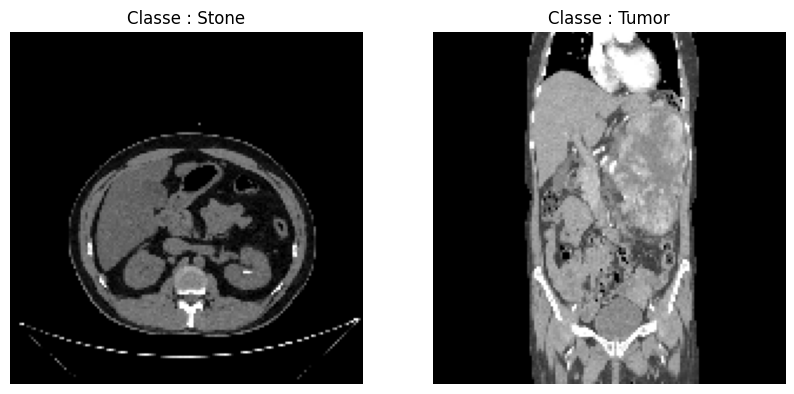

In [22]:
import os
import random
from tensorflow.keras.preprocessing import image

# Vérification visuelle
classes = ['Stone', 'Tumor'] # Tes vraies classes
plt.figure(figsize=(10, 5))

for i, class_name in enumerate(classes):
    folder = f"dataset_CT_kidney/train/{class_name}"
    # On prend une image au hasard
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    
    img = image.load_img(img_path, target_size=(150, 150))
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Classe : {class_name}")
    plt.axis('off')
plt.show()

In [23]:
# Pour VGG16, on n'utilise PAS rescale=1./255, mais la fonction de preprocessing dédiée
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input # <--- Changement CRUCIAL
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # <--- Changement CRUCIAL
)

training_set = train_datagen.flow_from_directory(
    "dataset_CT_kidney/train",
    target_size=(224, 224), # VGG aime le 224x224
    batch_size=32,
    class_mode="binary"
)

validation_set = val_datagen.flow_from_directory(
    "dataset_CT_kidney/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 3511 images belonging to 2 classes.
Found 1317 images belonging to 2 classes.


In [24]:
#Librairies d'optimisation
reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=3,min_lr=0.0001,verbose=1,mode="min")
early_stopping=EarlyStopping(monitor="val_loss",patience=3,mode="min",verbose=1)
callbacks=[early_stopping,reduce_lr]

In [25]:
# 1. Charger la base VGG16 pré-entraînée
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. "Geler" les couches (Freezing) pour ne pas casser ce qu'il a déjà appris
for layer in base_model.layers:
    layer.trainable = False

# 3. Ajouter notre tête de classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Pour éviter l'overfitting
predictions = Dense(1, activation='sigmoid')(x)

# 4. Créer le modèle final
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# Compilation
from tensorflow.keras.optimizers import Adam
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

model_vgg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
history = model_vgg.fit(
    training_set,
    validation_data=validation_set,
    epochs=10, # Ça devrait converger plus vite
    callbacks=callbacks
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7870 - loss: 2.2297 - val_accuracy: 0.9590 - val_loss: 0.1245 - learning_rate: 1.0000e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8869 - loss: 0.5050 - val_accuracy: 0.9795 - val_loss: 0.0619 - learning_rate: 1.0000e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9191 - loss: 0.2865 - val_accuracy: 0.9833 - val_loss: 0.0439 - learning_rate: 1.0000e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9254 - loss: 0.2422 - val_accuracy: 0.9749 - val_loss: 0.0687 - learning_rate: 1.0000e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9456 - loss: 0.1791 - val_accuracy: 0.9871 - val_loss: 0.0343 - learning_rate: 1.0000e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9590 - loss: 0.1239 - val_accuracy: 0.9924 - val_loss: 0.0269 - learning_rate: 1.0000e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - acc

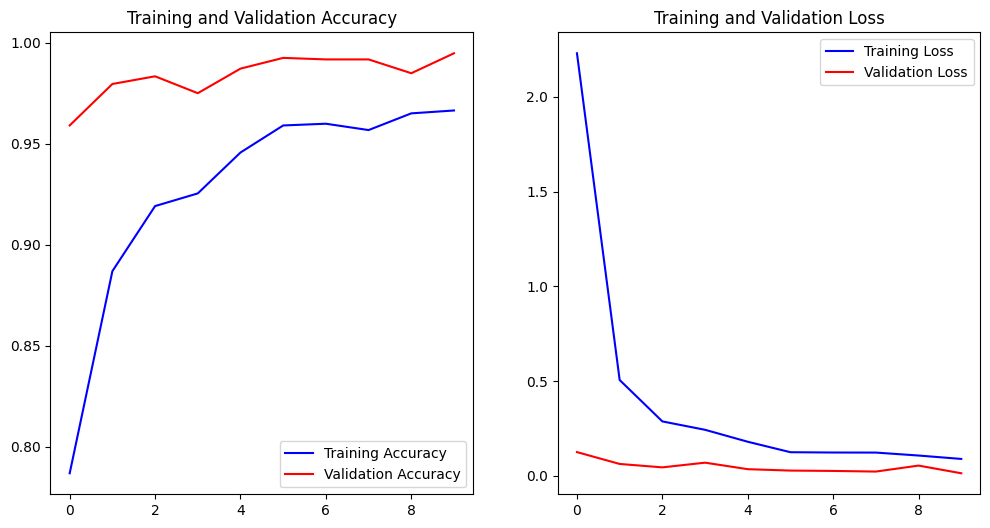

In [27]:
# Récupération des métriques
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step


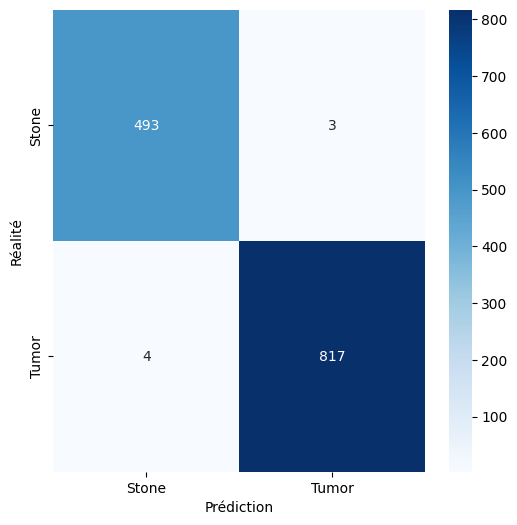

              precision    recall  f1-score   support

       Stone       0.99      0.99      0.99       496
       Tumor       1.00      1.00      1.00       821

    accuracy                           0.99      1317
   macro avg       0.99      0.99      0.99      1317
weighted avg       0.99      0.99      0.99      1317



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prédictions sur le jeu de validation
validation_set.reset() # Important pour remettre le générateur au début
Y_pred = model_vgg.predict(validation_set)
y_pred = (Y_pred > 0.5).astype(int)

# Matrice
cm = confusion_matrix(validation_set.classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stone', 'Tumor'], yticklabels=['Stone', 'Tumor'])
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

print(classification_report(validation_set.classes, y_pred, target_names=['Stone', 'Tumor']))

In [29]:
# On sauvegarde le modèle final pour l'utiliser dans Streamlit
model_vgg.save('modele_rein_vgg16.h5')
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !
